# Coarse-graining the Ideal Gas

Briefly look at the code for the ideal gas simulator and use the code to visualize it with a movie, then move on to making the plots and answering the questions in the Coarse-Graining Density section. Work together and be prepared to use your plots to answer questions in the debrief.

In [2]:
import numpy as np
from numpy.random import random
from numpy import sqrt, sin,cos, pi, array, dot
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats

import time
from time import perf_counter as clock

from matplotlib import animation, rc
from IPython.display import HTML
import tempfile; tempfile.tempdir='./'

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

## Ideal gas simulator

In [3]:
# modified from https://github.com/vpython/visual/blob/master/examples/gas.py
# converted to 2d, switched to pure numpy functions, visualization using matplotlib instead of vpython

# A model of an ideal gas with hard-sphere collisions
# Program uses Numeric Python arrays for high speed computations
k = 1.4E-23 # Boltzmann constant
Matom = 4E-3/6E23 # helium mass in kg

def simulate_gas(Natoms=1000, Nframes=500,  T=300, L=1, Ratom=0.003,dt=1E-5, start_half=False, start_uneven_energy=False):
# A model of an ideal gas with hard-sphere collisions
# Nframes is number of timesteps of dt to simulate
# T is temperature in K, L is box size in m, Ratom is atom radius in m, dt is timestep in seconds
# Returns poslist_frames -- list of postions of all atoms at each frame
#         plist_frames -- list of corresponding momenta of all atoms at each frame
#         wall_dp_frames -- sum of absolute value of momenta transfer to all 4 walls during each frame
    poslist = []
    plist = []
    mlist = []
    rlist = []

    # initialize the positions of the atoms
    for i in range(Natoms):
        Lmin = 1.1*Ratom
        Lmax = L-Lmin
        if (start_half): # start all of the atoms on the LHS of the box
          x = Lmin+0.5*(Lmax-Lmin)*random()
          y = Lmin+(Lmax-Lmin)*random()
        else:
          x = Lmin+(Lmax-Lmin)*random()
          y = Lmin+(Lmax-Lmin)*random()
    #   z = Lmin+(Lmax-Lmin)*random()
        r = Ratom
        mass = Matom*r**3/Ratom**3 # only would matter if we had different atom sizes
        pavg = sqrt(2.*mass*1.*k*T) # average kinetic energy p**2/(2mass) = (2/2)kT (2d gas)
        phi = 2*pi*random()
        if (start_uneven_energy and i>Natoms/2):
          px = 0
          py = 0
        else:
          px = pavg*cos(phi)
          py = pavg*sin(phi)
    #    pz = pavg*cos(theta)
        poslist.append((x,y))
        plist.append((px,py))
        mlist.append(mass)
        rlist.append(r)

    pos = array(poslist)
    p = array(plist)
    m = array(mlist)
    m.shape = (Natoms,1) # Numeric Python: (1 by Natoms) vs. (Natoms by 1)
    radius = array(rlist)

    t = 0.0
    Nsteps = 0
    pos = pos+(p/m)*(dt/2.) # initial half-step
    time = clock()

    poslist_frames = [pos];
    plist_frames = [p];
    wall_dp_frames = [0];

    while (Nsteps < Nframes):
        # Update all positions
        pos = pos+(p/m)*dt

        r = pos-pos[:,np.newaxis] # all pairs of atom-to-atom vectors
        rmag = sqrt(np.sum(r*r,-1)) # atom-to-atom scalar distances
        hit = np.less_equal(rmag,radius+radius[:,np.newaxis])-np.identity(Natoms)
        hitlist = np.sort(np.nonzero(hit.flatten())).tolist()[0]# i,j encoded as i*Natoms+j    
        # If any collisions took place:

        hitlist_nodups = hitlist
        for ij in hitlist:
            i, j = np.divmod(ij,Natoms) # decode atom pair
            hitlist_nodups.remove(j*Natoms+i) # remove symmetric j,i pair from list

        for ij in hitlist_nodups:
            i, j = np.divmod(ij,Natoms) # decode atom pair
            #print(i,j, np.sqrt(np.sum((pos[i]-pos[j])**2)))
            ptot = p[i]+p[j]
            mi = m[i,0]
            mj = m[j,0]
            vi = p[i]/mi
            vj = p[j]/mj
            ri = radius[i]
            rj = radius[j]
            a = np.linalg.norm(vj-vi)**2
            if a == 0: continue # exactly same velocities
            b = 2*dot(pos[i]-pos[j],vj-vi)
            c = np.linalg.norm(pos[i]-pos[j])**2-(ri+rj)**2
            d = b**2-4.*a*c
            if d < 0: continue # something wrong; ignore this rare case
            deltat = (-b+sqrt(d))/(2.*a) # t-deltat is when they made contact
            pos[i] = pos[i]-(p[i]/mi)*deltat # back up to contact configuration
            pos[j] = pos[j]-(p[j]/mj)*deltat
            mtot = mi+mj
            pcmi = p[i]-ptot*mi/mtot # transform momenta to cm frame
            pcmj = p[j]-ptot*mj/mtot
            rrel = (pos[j]-pos[i])/np.linalg.norm(pos[j]-pos[i])
            #print(pcmi,pcmj, rrel)
            #print(dot(pcmi,rrel))
            pcmi = pcmi-2*dot(pcmi,rrel)*rrel # bounce in cm frame
            pcmj = pcmj-2*dot(pcmj,rrel)*rrel
            #print(pcmi,pcmj)
            #print(p[i],p[j],pos[i],pos[j])
            p[i] = pcmi+ptot*mi/mtot # transform momenta back to lab frame
            p[j] = pcmj+ptot*mj/mtot
            pos[i] = pos[i]+(p[i]/mi)*deltat # move forward deltat in time
            pos[j] = pos[j]+(p[j]/mj)*deltat
            #print(p[i],p[j],pos[i],pos[j])


        # Bounce off walls
        wall_dp = 0

        outside = np.less_equal(pos,Ratom) # walls closest to origin
        p1 = p*outside
        pnew = p-p1+abs(p1)
        wall_dp += np.sum(abs(p - pnew)) #calculate contributions to pressure        
        p = pnew # force p component inward

        outside = np.greater_equal(pos,L-Ratom) # walls farther from origin
        p1 = p*outside
        pnew = p-p1-abs(p1) # force p component inward
        wall_dp += np.sum(abs(p - pnew)) #calculate contributions to pressure        
        p = pnew # force p component inward

        poslist_frames.append(pos) # save the positions for this frame
        wall_dp_frames.append(wall_dp) # save the momentum transfer to the wall
        plist_frames.append(p)

        Nsteps = Nsteps+1
        t = t+dt

        if Nsteps%50==0:
            print('%3.1f seconds for %d steps with %d Atoms' % (clock()-time, Nsteps, Natoms))
    ##    rate(30)

    return poslist_frames, plist_frames, wall_dp_frames

## Simulator animations

You can verify that the simulator is working by creating a movie of its time updates, no need to write any code here.

In [6]:
# matplotlib jupyter animations based on http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/

def animate_gas(poslist_frames,Ratom_anim = 0.003, L_anim = 1):
    # Generate animation
    width = 4 # width of plot in inches

    # set-up figure and ax
    fig, ax = plt.subplots(figsize=(width,width))
    ax.set_xlim((0, 1))
    ax.set_ylim((0, 1))
    simgraph = ax.scatter([], [])

    # convert atom size to figure units
    t = ax.transAxes.transform([(0,0), (Ratom_anim,Ratom_anim)])
    Ratom_pts = (t[1,1]-t[0,0]) * 72/fig.dpi
    s_circ = (Ratom_pts * 2)**2

    def init_model():
        ax.set_xlim((0, 1))
        ax.set_ylim((0, 1))
        simgraph = ax.scatter([], [])
        return (simgraph,)

    def animate_model(i):
        ax.clear()
        ax.set_xlim((0, 1))
        ax.set_ylim((0, 1))
        simgraph = ax.scatter(poslist_frames[i][:,0], poslist_frames[i][:,1], s=s_circ)
        return (simgraph,)

    print("here is first frame, when ready may need to click 'fetch additional output' to watch movie:")
    animate_model(1)
    plt.show()

    # run to generate the html5 video of the positions
    # (takes about 30s for 100 frames)
    # click 'Fetch additional output to see'
    anim = animation.FuncAnimation(fig, animate_model, init_func=init_model,
                                  frames=len(poslist_frames), interval=40)
    
    if IN_COLAB: # colab
      return HTML(anim.to_html5_video())
    else: # cocalc
      fname = tempfile.mktemp('.gif')
      print(fname)
      anim.save(fname)
      time.sleep(0.1) # make sure file is saved
      return display(HTML("""
                  <image style="width:200" src="{}" >
                  """.format(fname)))


0.0 seconds for 50 steps with 100 Atoms
0.1 seconds for 100 steps with 100 Atoms
here is first frame, when ready may need to click 'fetch additional output' to watch movie:


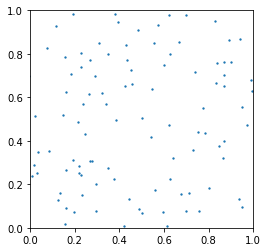

MovieWriter ffmpeg unavailable; using Pillow instead.


./tmpj6__i1tu.gif


In [7]:
# example:

Natoms = 100
Nframes = 100

Ratom = 0.003
L = 1

# Run the model
poslist_frames, plist_frames, wall_dp_frames = simulate_gas(Natoms=Natoms, Nframes=Nframes, Ratom=Ratom, L = L)

animate_gas(poslist_frames[:100], Ratom_anim=Ratom, L_anim = L) # best practice, only visualize 100 frames or movie takes a long time to generate

## Get data from simulation and visualize


In [8]:

# set simulation parameters
Natoms = 500
Nframes = 1000
dt = 1E-5 # s
T=300 # Kelvin
Ratom = 0.003 # meters -- grossly exagerated
L = 1 # meters

# Run the simulator to get data (takes about 1m for 5000 steps with 500 atoms)
poslist_frames, plist_frames, wall_dp_frames = simulate_gas(Natoms=Natoms, Nframes=Nframes, Ratom=Ratom, L = L, dt=dt, T=T, start_half=True)

0.7 seconds for 50 steps with 500 Atoms
1.4 seconds for 100 steps with 500 Atoms
2.1 seconds for 150 steps with 500 Atoms
2.8 seconds for 200 steps with 500 Atoms
3.5 seconds for 250 steps with 500 Atoms
4.2 seconds for 300 steps with 500 Atoms
4.9 seconds for 350 steps with 500 Atoms
5.8 seconds for 400 steps with 500 Atoms
6.5 seconds for 450 steps with 500 Atoms
7.2 seconds for 500 steps with 500 Atoms
7.8 seconds for 550 steps with 500 Atoms
8.4 seconds for 600 steps with 500 Atoms
9.0 seconds for 650 steps with 500 Atoms
9.6 seconds for 700 steps with 500 Atoms
10.2 seconds for 750 steps with 500 Atoms
10.8 seconds for 800 steps with 500 Atoms
11.4 seconds for 850 steps with 500 Atoms
12.1 seconds for 900 steps with 500 Atoms
12.7 seconds for 950 steps with 500 Atoms
13.4 seconds for 1000 steps with 500 Atoms


here is first frame, when ready may need to click 'fetch additional output' to watch movie:


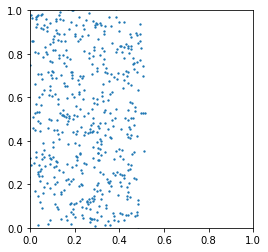

MovieWriter ffmpeg unavailable; using Pillow instead.


./tmpl718jj6w.gif


In [9]:
# visualize

animate_gas(poslist_frames[:100], Ratom_anim=Ratom, L_anim=L) # first 100 frames, pretty slow to make movie for more

## Pressure coarse-graining (homework - PS1 p4)

The array wall_dp_frames contains the total momentum transferred to all the walls in each time step (normal to each wall), and the array list p_frames is a list of the (px,py) tuples for each particle at each time step.

0. Run the simulation for 500 atoms and 2000 timesteps.
1. Produce a plot of dp_wall vs. time. 
2. Use the function running_gaussian_convolve to plot the time-averaged dp_wall vs. time for widths of w=5,10,25,50,100. Explain the shapes of these plots. (the gaussian filter is a weighted average where the weight of a point is determined by its distance from the center of the filter using a gaussian distribution -- it is a way of producing smoothly varying averages as opposed to a simple moving window)
3. Check if your result is consistent with the 2d ideal gas law, P*A = NkT, where A is the area and T is related to the average kinetic energy per particle by  $$T = <E_{kin}>/k = <(px^2 + py^2)/2m>/k$$ (note the variables Matom and k contain the mass of the particle and the boltzmann constant in simulation units all ready)
4. Plot the distribution of p_x in equilibrium to see if it agrees with the elf-king prediction or not.

In [15]:
# efficiently compute a gaussian convolution of width w over the data x
def running_gaussian_convolve(x,w):
    gx=np.arange(-2*w,2*w,1)
    g=1/np.sqrt(2*np.pi*w**2) * np.exp(-np.power(gx,2)/(2 * w**2))
    return np.convolve(x, g,mode='valid')

# set simulation parameters
Natoms = 500
Nframes = 2000
dt = 1E-5 # s
T=300 # Kelvin
Ratom = 0.003 # meters -- grossly exagerated
L = 1 # meters

# Run the simulator to get data (takes about 1m for 5000 steps with 500 atoms)
poslist_frames, plist_frames, wall_dp_frames = simulate_gas(Natoms=Natoms, Nframes=Nframes, Ratom=Ratom, L = L, dt=dt, T=T, start_half=True)

0.7 seconds for 50 steps with 500 Atoms
1.4 seconds for 100 steps with 500 Atoms
2.1 seconds for 150 steps with 500 Atoms
2.7 seconds for 200 steps with 500 Atoms
3.4 seconds for 250 steps with 500 Atoms
4.0 seconds for 300 steps with 500 Atoms
4.7 seconds for 350 steps with 500 Atoms
5.3 seconds for 400 steps with 500 Atoms
6.0 seconds for 450 steps with 500 Atoms
6.6 seconds for 500 steps with 500 Atoms
7.2 seconds for 550 steps with 500 Atoms
7.9 seconds for 600 steps with 500 Atoms
8.5 seconds for 650 steps with 500 Atoms
9.2 seconds for 700 steps with 500 Atoms
9.8 seconds for 750 steps with 500 Atoms
10.5 seconds for 800 steps with 500 Atoms
11.1 seconds for 850 steps with 500 Atoms
11.7 seconds for 900 steps with 500 Atoms
12.3 seconds for 950 steps with 500 Atoms
13.0 seconds for 1000 steps with 500 Atoms
13.6 seconds for 1050 steps with 500 Atoms
14.2 seconds for 1100 steps with 500 Atoms
14.9 seconds for 1150 steps with 500 Atoms
15.5 seconds for 1200 steps with 500 Atoms
16.

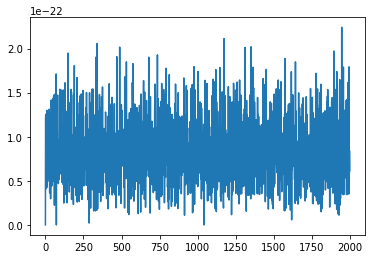

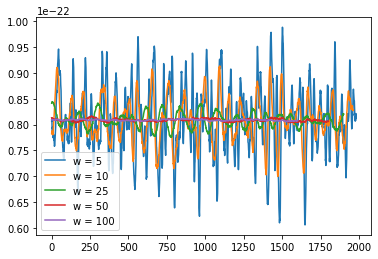

In [18]:
# 1,2 - your code here to plot dp_wall vs time (and convolutions)
t = range(len(wall_dp_frames))

plt.plot(t,wall_dp_frames)
plt.show()

ws=[5,10,25,50,100]

for w in ws:
    y = running_gaussian_convolve(wall_dp_frames,w)
    t = range(len(y))
    plt.plot(t, y, label=f'w = {w}')

plt.legend()
plt.show()
    

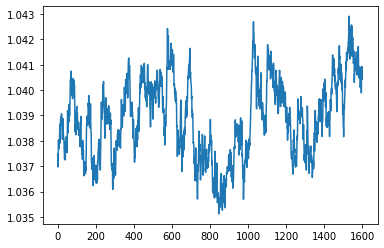

In [42]:
# 3 - your code here to check the ideal gas law

#P = (N/A)*k*<(px*2+py*2)/2m>/k
# = (N/A)*<(px*2+py*2)/2m>

def igl(data, m, N, L):
    Ps = []
    A = L**2
    for i in data:
        T = []
        for j in i:
            T.append((j[0]**2 + j[1]**2)/(2*m))
        P = (N/A)*np.mean(T)
        Ps.append(P)
    return Ps

igP = igl(plist_frames, Matom, Natoms, L)

p = np.array(running_gaussian_convolve(wall_dp_frames,100))/dt/4

y = igP[:len(p)]/p

plt.plot(range(len(y)), y)
plt.show()


For this question, I'm calculating the preassure using the Ideal Gas Law, and then also calculating it using the dp/dt formula and dividing by 4 (4 walls). Divinging one by the other for every timestep, I get a fluctuation around something very close to 1, so the result is consistent

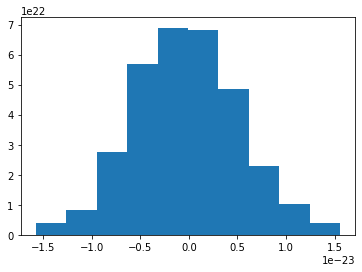

In [31]:
# 4 - your code here to plot the p_x momentum distribution
y = [i[0] for i in plist_frames[-1]]

plt.hist(y, density=True)
plt.show()

I dont know what the elf-king prediction is, but it looks normally distributed <br>

Also, changed a few things in this code so the animation runs locally, and the time.clock is substituted by time.perf_counter